In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch


labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.double}
save_dir = "mse_scale_0.95_l_1e13_bw"
data_dir = "."
quad_strengths, image_data, bins, xx = load_data(tkwargs)
bins = bins * 1e3
xx = xx * 1e3
train_dset = torch.load(f"{data_dir}/train.dset")
test_dset = torch.load(f"{data_dir}/test.dset")

quad_strengths = quad_strengths[:2,:2]
image_data = image_data[:2,:2]

print(image_data.shape)
bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2

ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

ensemble = ensemble[0]

n_particles = 1000000
ensemble.beam.set_base_beam(
        ensemble.beam.base_dist,
        n_particles,
        p0c=torch.tensor(63.0e6)
    )

ensemble = ensemble.cuda()


/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2, 2, 500, 500])


/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
from phase_space_reconstruction.utils import calculate_ellipse
offset = 0
# calculate rms stats from each image
covs = []
centroids = []
image_data = torch.clip(image_data, offset) - offset
for ele in image_data.transpose(-1,-2):
    centroid, cov = calculate_ellipse(ele, bins, bins)
    covs += [cov]
    centroids += [centroid]

covs = torch.stack(covs).sqrt().detach().cpu()
centroids = torch.stack(centroids)

# plot reconstruction covs
rcovs = []
predictions = []
with torch.no_grad():
    for j in range(len(quad_strengths)):
        p, _, _ = ensemble(quad_strengths[j,:,:].cuda())
        p = torch.clip(p.cpu(), offset) - offset
        centroid, cov = calculate_ellipse(p.transpose(-2,-1), bins, bins)
        rcovs += [cov]

        predictions += [p]

        torch.cuda.empty_cache()
            
rcovs = torch.stack(rcovs).sqrt().transpose(0,1)
rcovs_mean = rcovs.mean(dim=[1,2])
rcovs_std = rcovs.std(dim=[1,2])


In [3]:
print(covs.shape)
print(rcovs.shape)
print(predictions[0].shape)
print(bin_width)

torch.Size([2, 2, 2, 2])
torch.Size([2, 2, 2, 2])
torch.Size([2, 500, 500])
tensor(0.0416, dtype=torch.float64)


tensor(nan, dtype=torch.float64) tensor(nan, dtype=torch.float64)
tensor(1.7852, dtype=torch.float64) tensor(0.2950, dtype=torch.float64)


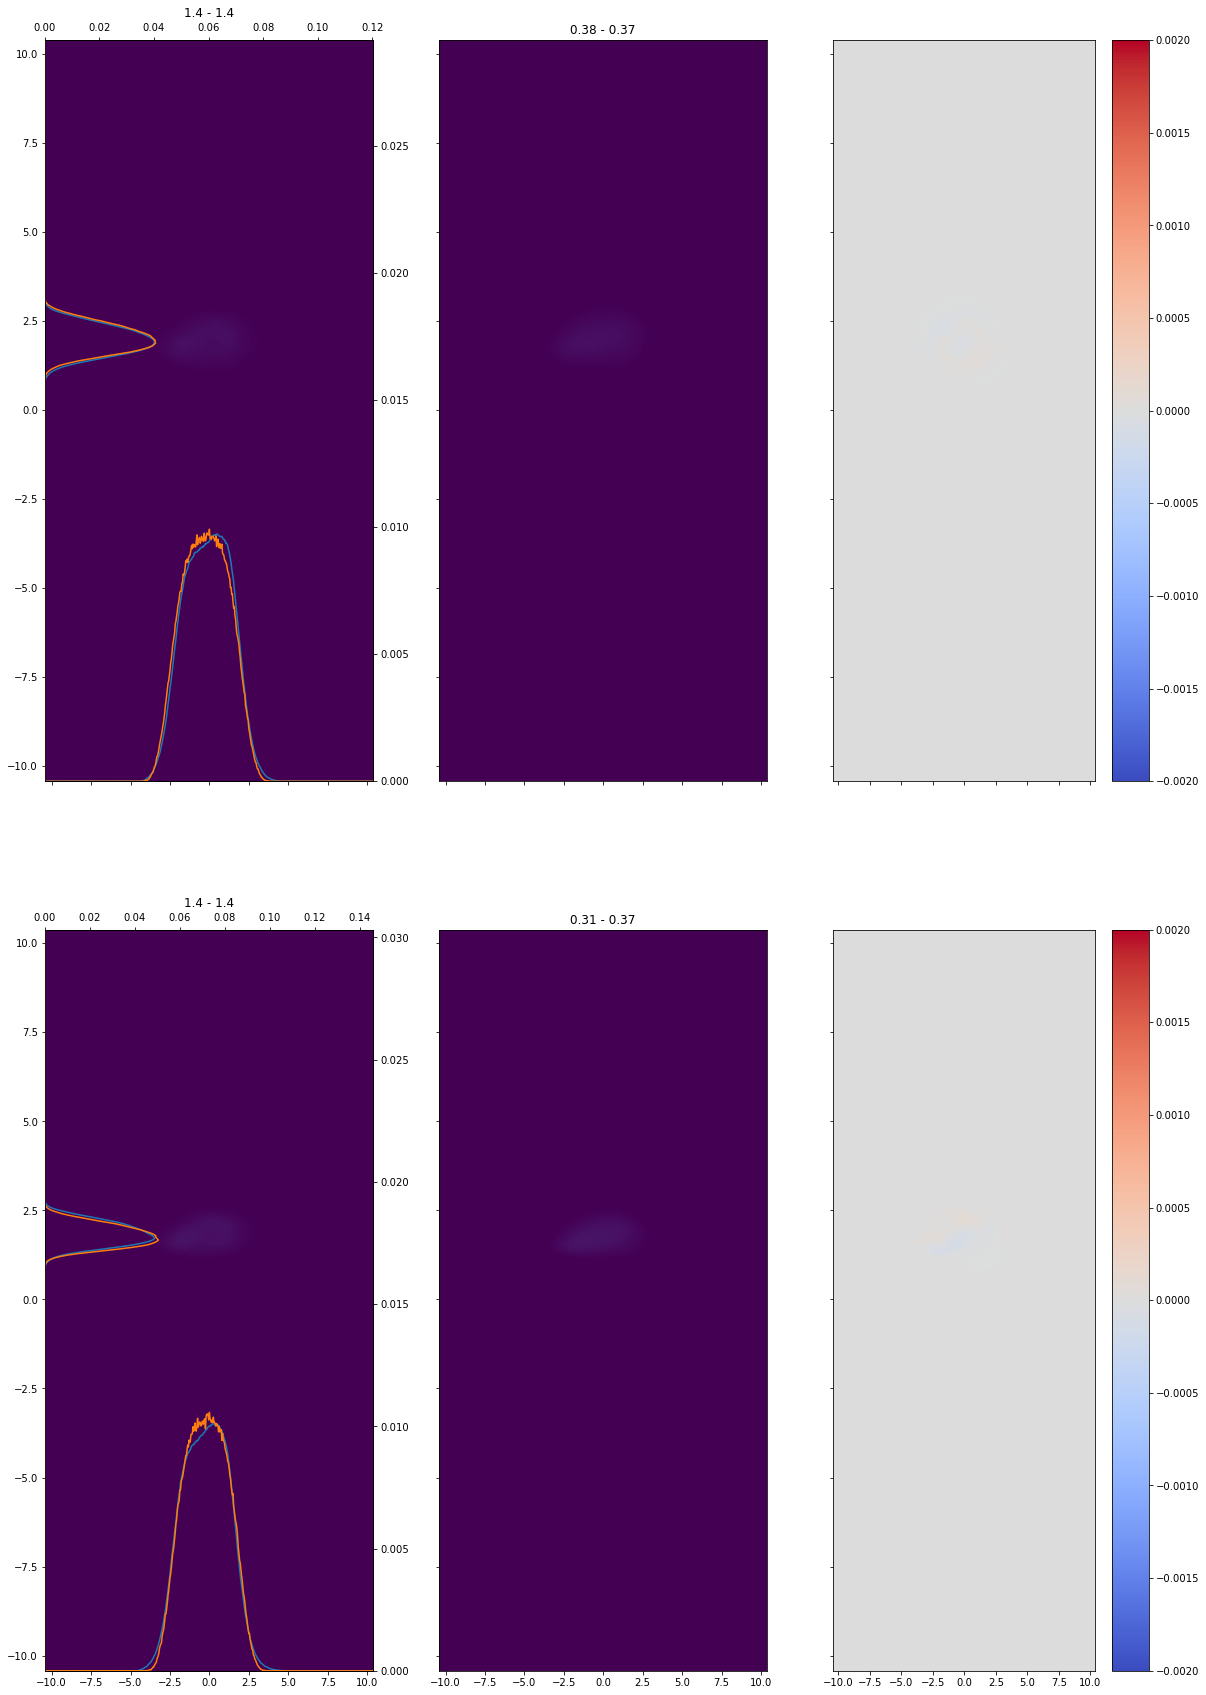

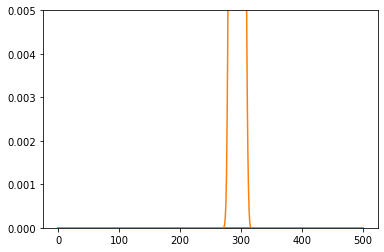

In [4]:
import numpy as np
indicies = [0,1]

fig,ax = plt.subplots(len(indicies),3,sharex="all", sharey="all")
fig.set_size_inches(20,30)
shot_index = 0

for i, index in enumerate(indicies):
    
    # get images
    gt_image = image_data[index][shot_index].cpu().detach()
    pred_image = predictions[index][shot_index].cpu().detach()
    
    # 
    
    gt_projs = []
    pred_projs = []
    for ele in [-2,-1]:
        gt_projs += [gt_image.sum(dim=ele)]
        pred_projs += [pred_image.sum(dim=ele)]
    
    ax[i][0].pcolor(*xx,gt_image,
                    vmin=0,vmax=0.01
                    )
    ax[i][1].pcolor(*xx,pred_image, 
                    vmin=0,vmax=0.01)

    c = ax[i][2].pcolor(*xx,gt_image - pred_image,cmap="coolwarm",vmin=-2e-3, vmax=2e-3)
    fig.colorbar(c, ax=ax[i][2])
    axb = ax[i][0].twinx()
    axb.plot(bins, gt_projs[0])
    axb.plot(bins, pred_projs[0])
    axb.set_ylim(0.0, gt_projs[0].max()*3)
    
    axc = ax[i][0].twiny()
    axc.plot(gt_projs[1],bins)
    axc.plot(pred_projs[1],bins)
    axc.set_xlim(0.0, gt_projs[1].max()*3)
    
    axb.set_title(f"{covs[index,shot_index,1,1]:.2} - {rcovs[index,shot_index,1,1]:.2}")
    ax[i][1].set_title(f"{covs[index,shot_index,0,0]:.2} - {rcovs[index,shot_index,0,0]:.2}")

plt.figure()

#manually remove noise
gt_projs[1][:120] = 0.
gt_projs[1][165:] = 0.

plt.plot(gt_projs[1])
plt.plot(pred_projs[1])
plt.ylim(0,5e-3)
# calculate rms from proj
def weighted_stats(x, vals):
    weighted_mean = (x * vals).sum() / vals.sum()
    weighted_rms = ((x - weighted_mean)**2 * vals).sum() / vals.sum()
    return weighted_mean, weighted_rms




# clip
#lb = 1e-3
#gt_projs[1] = torch.clip(gt_projs[1],lb) - lb
#pred_projs[1] = torch.clip(pred_projs[1],lb) - lb

#plt.axhline(lb)

m, rms = weighted_stats(bins, gt_projs[1])
print(m, rms.sqrt())
m, rms = weighted_stats(bins, pred_projs[1])
print(m, rms.sqrt())
